In [2]:
# IMPORT STATEMENTS
import re
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import sys
sys.path.append("/booleanfs2/sahoo/Hegemon")
sys.path.append("../")
import StepMiner as smn
import HegemonUtil as hu
import os
acolor = ["#00CC00", "#D8A03D","#EC008C",
          'cyan', "#B741DC", "#808285",
          'blue', 'black', 'green', 'red',
          'orange', 'brown', 'pink', 'purple']
try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
cf = '/Users/dtv004/public_html/Hegemon/explore.conf'

In [3]:
# Daniella's code for generating figures

def getPDF(cfile):
    from matplotlib.backends.backend_pdf import PdfPages
    pdf = PdfPages(cfile)
    return pdf

def closePDF(pdf):
    import datetime
    d = pdf.infodict()
    d['Title'] = 'Plots'
    d['Author'] = 'Daniella Vo'
    d['Subject'] = "BoNE Examples"
    d['Keywords'] = 'disease training validation ROC'
    d['CreationDate'] = datetime.datetime(2021, 7, 6)
    d['ModDate'] = datetime.datetime.today()
    pdf.close()
    
def plotViolinBar(ana, desc=None):
    fig = plt.figure(figsize=(4,4), dpi=100)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    ax1 = plt.subplot2grid((4, 1), (0, 0))
    ax2 = plt.subplot2grid((4, 1), (1, 0), rowspan=3)
    params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1,
              'genes': [], 'ax': ax1, 'acolor': acolor}
    ax = ana.printTitleBar(params)
    res = ana.getROCAUC()
    ax.text(len(ana.cval[0]), 4, res)
    if desc is not None:
        ax.text(-1, 2, desc, horizontalalignment='right',
                    verticalalignment='center')
    params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1,
            'genes': [], 'ax': ax2, 'acolor': acolor, 'vert': 0}
    ax = ana.printViolin(None, params)
    return fig
    
def plotDensityBar(ana, desc=None):
    fig = plt.figure(figsize=(4,4), dpi=100)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    ax1 = plt.subplot2grid((4, 1), (0, 0))
    ax2 = plt.subplot2grid((4, 1), (1, 0), rowspan=3)
    params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1,
              'genes': [], 'ax': ax1, 'acolor': acolor}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    ax.text(len(ana.cval[0]), 4, ",".join(res))
    if desc is not None:
        ax.text(-1, 2, desc, horizontalalignment='right',
                    verticalalignment='center')
    ax = ana.densityPlot(ax2, acolor)
    return fig

def processData(ana, l1, wt1, desc=None, violin=1):
    ana.orderData(l1, wt1)
    if (violin == 1):
        return plotViolinBar(ana, desc)
    return plotDensityBar(ana, desc)

def readGenes(cfile):
    if not os.path.isfile(cfile):
        print("Can't open file")
        exit()
    fp = open(cfile, "r")
    nodelist = []
    for line in fp:
        line = line.strip();
        ll = re.split("[\[\]()\s]", line);
        nodelist += ll
    fp.close();
    return [i for i in hu.uniq(nodelist) if i != '']

# gets the clusters from the preiouvsly built adenoma network. Should write a function like this for each method.
def getGeneGroupsAdenoma(ana, order = None, weight = None, debug = 1):
    
    db = hu.Database("/booleanfs2/sahoo/Hegemon/explore.conf")
    h = hu.Hegemon(db.getDataset("PLP33"))
    h.init()
    h.initPlatform()
    h.initSurv()
    dir1 = "/booleanfs2/sahoo/Data/Colon/Adenoma/"
    cfile = dir1 + "Supplementary/colon-network-clusters.txt" # clusters in the network
    if not os.path.isfile(cfile):
        print("Can't open file {0}".format(cfile));
        exit()
    fp = open(cfile, "r")
    nodelist = {}
    nhash = {}
    for line in fp:
        line = line.strip();
        ll = line.split("\t");
        nodelist[ll[0]] = ll[2:]
        for i in ll[2:]:
            nhash[i] = ll[0];
    fp.close();
    gene_groups = [[]]
    for i in range(1, 16):
        cfile = dir1 + "Supplementary/node-" + str(i) + ".txt"
        res = readGenes(cfile)
        s1 = set()
        for g in res:
            s1.add(g)
            if g in nodelist:
                for k in nodelist[g]:
                    s1.add(k)
        gene_groups.append(s1);
        if debug == 1:
            print(i, res[0], h.getSimpleName(res[0]), len(s1))
    print([len(s) for s in gene_groups])
    if order is None:
        order = [1, 2, 3, 4]
    gene_groups = [gene_groups[i] for i in order]
    print([len(s) for s in gene_groups])
    #gene_groups = getSimpleName(gene_groups, h)
    #print([len(s) for s in gene_groups])
    if weight is None:
        weight = [-3, -2, -0.5, 2]
    print(weight)
    genes = readGenes(dir1 + "cluster-names.txt")
    return genes, weight, gene_groups

In [6]:
# add a class in bone.py to get your data from main Hegemon or your Hegemon

# example in class IBDAnanlysis(): 

def getPetersDf(self, tn=1):
    self.prepareDataDf("PLP7")
    atype = hu.getHegemonPatientData(self.dbid, 'c clinical condition')[1]
    ahash = {'Ulcerative Colitis':1, 'control':0, "Crohn's disease":2}
    atypes = ['Normal', 'UC', 'CD']
    # in this if statement, see if we want to analyze UC and CD separately or combined.
    # this assigns 1 to UC and CD which are types of IBD, hence combining them into a single type IBD.
    if (tn == 2):
        atypes = ['Normal', 'IBD']
        ahash = {"control": 0, "Ulcerative Colitis":1, "Crohn's disease":1} 
    self.initData(atype, atypes, ahash)

# example in class BESAnalysis

import bone
reload(bone)
class BESAnalysis(bone.IBDAnalysis): # BESAnalysis extends IBDAnalysis so it has all of its methods

    def __init__(self):
        '''Initializes IBD class'''
        bone.IBDAnalysis.__init__(self)
    
    def getSen2020(self, tn=1):
        '''Gets and prepares data from dataset Sen 2020'''
        self.prepareData("BE1", cfile=cf) # cf refers to explore.conf file.
        atype = self.h.getSurvName("c protocol") # select the desired column
        ahash = {'SPT6':1, 'CTL':0}  # SPT6 knockout versus control
        atypes = ['CTL', 'SPT6 KO']
        if tn == 2:
            ahash = {'SPT6':0, 'CTL':1}
            atypes = ['SPT6 KO', 'CTL']
        self.initData(atype, atypes, ahash) # Initialize dataset with desired columns and conditions
        
# example in class PolypAnalysis

class PolypAnalysis(bone.IBDAnalysis):
    def __init__(self):
        bone.IBDAnalysis.__init__(self)
        
    def getPGFuso2021(self, tn=1):
        self.prepareData("PG0.5", cfile="/Users/dtv004/public_html/Hegemon/explore.conf")
        atype = self.h.getSurvName('c Sample ID')
        
        atypes = ['H', 'Adult NI', 'Adult P']
        ahash = {'H9_S73':0, 'org_H14_Colon_p13_S1':0,
                 'NI_ADULT_S72':1, 'C112216_S47':2}
            
        if tn == 4: # tn parameter just allows us to select/certain clinical characeteristics from the survival file
            atypes = [ 'H', 'NI PED', 'P PED']
            ahash = {'H9_S73':0, 'org_H14_Colon_p13_S1':0,
                     'FAP1_NI_S40':1, 'FAP_7_NI_S45':1, 'Lynch_2_TCNI_S43':1, 'Lynch1_no_PF_S51':1,
                     'FAP1_polyp_S41':2, 'FAP4_polyp_S42':2, 'FAP_7_polyp_S46':2, 'PJS1_TC_polyp_S44':2}
            
        self.initData(atype, atypes, ahash)   

Sen 2020 SPT6 (n = 6)
GSE153129 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=BE1
6 [3, 3] GSE153129 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=BE1 BE1
[8, 21]


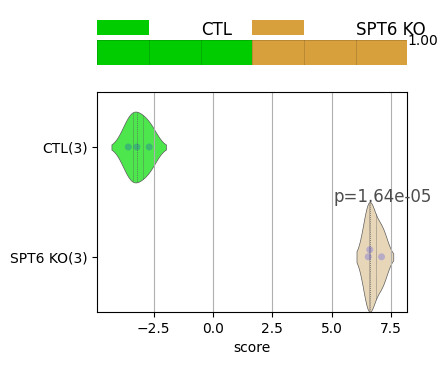

In [5]:
# EXAMPLE from BEAnalysis
# Simple Rank Ordering based on Up/Down-regulated Genes

import bone 
reload(bone)
ana = BESAnalysis() # generate instance of class
ana.getSen2020() # Get data

# list of genes that are upregulated in Barrett's Esophagus
f = open('bemisc/gsea-be-up.txt','r')
lines = f.readlines()[2:]
f.close()
up = [x.strip() for x in lines]

# list of genes that are downregulated
f = open('bemisc/gsea-be-down.txt','r')
lines = f.readlines()[2:]
f.close()
down = [x.strip() for x in lines]
l1 = [up, down]

#  weights: positive for upregulated, negative for downregulated
wt1 = [1, -1]

# Generate violin plot by rank ordering based on the up/down gene lists
# See figure in BEAnalysis notebook. Perfectly ordered!
fig = processData(ana, l1, wt1, None, 1)

Polyp - Fusoboolean Human 2020 (n = 12)
 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=PG0.5
4 [2, 1, 1]  http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=PG0.5 PG0.5
[0, 16, 152, 130, 122, 29, 406, 1530, 775, 33, 25, 9, 36, 516, 153, 188]
[16, 152, 130, 122, 29]
[-5, -0.3, 0.1, 2.9, -4]
[15, 152, 121, 105, 27]
[0, 16, 152, 130, 122, 29, 406, 1530, 775, 33, 25, 9, 36, 516, 153, 188]
[16, 152, 122]
[-2, -1, 1]
[15, 152, 105]


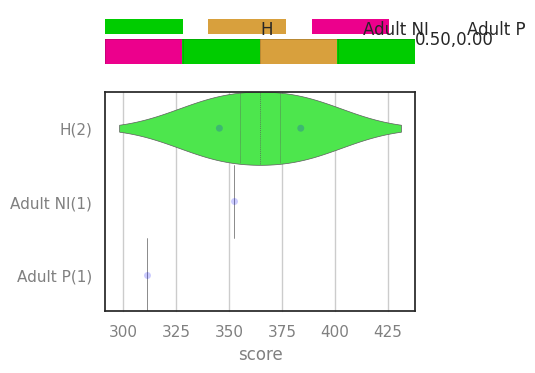

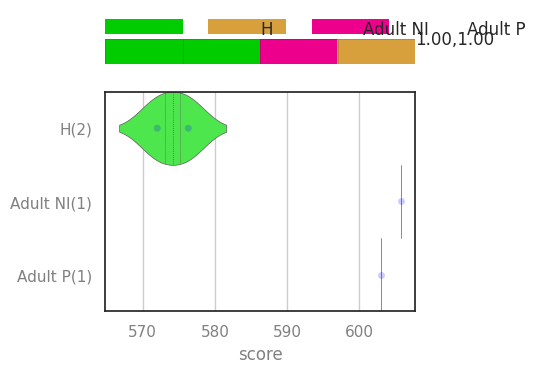

In [8]:
import bone
reload(bone)
ana = PolypAnalysis()
ana.getPGFuso2021()

# Cluster 1-2-3-4-5
# This is a path in the previously built adenoma network leading
# from initation to propoagation to perpetuation of the cancer.
order = [1, 2, 3, 4, 5]
wt1 = [-5, -0.3, 0.1, 2.9, -4] # Ask Dr Sahoo how to decide weights
genes, wt1, l1 = getGeneGroupsAdenoma(ana, order, wt1, 0)
fig = processData(ana, l1, wt1, None, 1) 
# Classification not useful, ROC/AUC 0.5. This could be because there are very few samples.

# Cluster 1-2-4
order = [1, 2, 4]
wt1 = [-2, -1, 1]
genes, wt1, l1 = getGeneGroupsAdenoma(ana, order, wt1, 0)
fig = processData(ana, l1, wt1, None, 1)
# Works much better!

Polyp - Fusoboolean Human 2020 (n = 12)
 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=PG0.5
10 [2, 4, 4]  http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=PG0.5 PG0.5
[0, 16, 152, 130, 122, 29, 406, 1530, 775, 33, 25, 9, 36, 516, 153, 188]
[16, 152, 130, 122, 29]
[-5, -0.3, 0.1, 2.9, -4]
[15, 152, 121, 105, 27]
[0, 16, 152, 130, 122, 29, 406, 1530, 775, 33, 25, 9, 36, 516, 153, 188]
[16, 152, 122]
[-2, -1, 1]
[15, 152, 105]


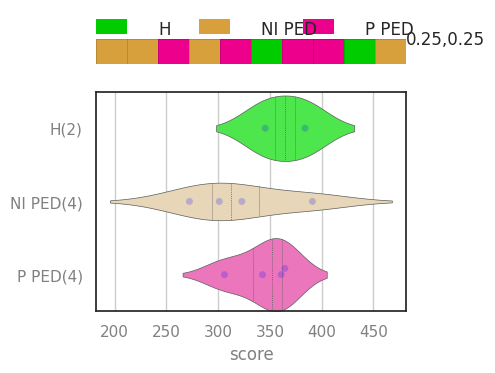

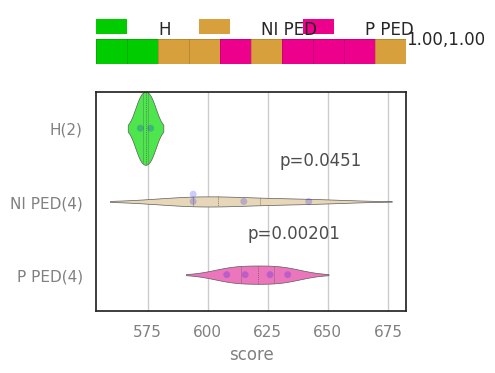

In [9]:
# Same as previous cell, but includes pediatric samples this time.
import bone
reload(bone)
ana = PolypAnalysis()
ana.getPGFuso2021(4) # sets tn = 4 to include pediatric samples.

# Cluster 1-2-3-4-5 (Doesn't work that well)
order = [1, 2, 3, 4, 5]
wt1 = [-5, -0.3, 0.1, 2.9, -4]
genes, wt1, l1 = getGeneGroupsAdenoma(ana, order, wt1, 0)
fig = processData(ana, l1, wt1, None, 1)

# Cluster 1-2-4 (Works well)
order = [1, 2, 4]
wt1 = [-2, -1, 1]
genes, wt1, l1 = getGeneGroupsAdenoma(ana, order, wt1, 0)
fig = processData(ana, l1, wt1, None, 1)